In [1]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode
from langchain_community.tools import TavilySearchResults
from IPython.display import Image

In [14]:
#pip install langchain_tavily

In [ ]:
import os
os.environ['TAVILY_API_KEY'] = ''

In [4]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Notice we're using an in-memory checkpointer. This is convenient for our tutorial (it saves it all in-memory). In a production application, you would likely change this to use SqliteSaver or PostgresSaver and connect to your own DB.

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_tavily import TavilySearch

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearch(max_results=2)
tools = [tool]

# class State(TypedDict):
#     # Messages have the type "list". The `add_messages` function
#     # in the annotation defines how this state key should be updated
#     # (in this case, it appends messages to the list, rather than overwriting them)
#     messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = ''


Next, add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.

In [7]:
#llm = ChatOpenAI(model='gpt-4.1', temperature=0)
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

In [8]:
#from langchain.chat_models import init_chat_model

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

#Finally, compile the graph with the provided checkpointer.
graph = graph_builder.compile(checkpointer=memory)


# def chatbot(state: State):
#     return {"messages": [llm.invoke(state["messages"])]}


# # The first argument is the unique node name
# # The second argument is the function or object that will be called whenever
# # the node is used.
# graph_builder.add_node("chatbot", chatbot)

Next, add an entry point. This tells our graph where to start its work each time we run it.

In [6]:
#graph_builder.add_edge(START, "chatbot")

Similarly, set a finish point. This instructs the graph "any time this node is run, you can exit."

In [7]:
#graph_builder.add_edge("chatbot", END)

Finally, we'll want to be able to run our graph. To do so, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.

In [8]:
#graph = graph_builder.compile()

You can visualize the graph using the get_graph method and one of the "draw" methods, like draw_ascii or draw_png. The draw methods each require additional dependencies.

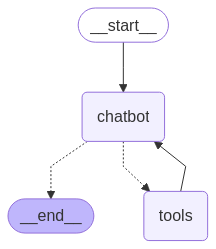

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now let's run the chatbot!

Tip: You can exit the chat loop at any time by typing "quit", "exit", or "q".

Now you can interact with your bot! First, pick a thread to use as the key for this conversation.

In [9]:
config = {"configurable": {"thread_id": "1"}}

In [10]:
#Next, call your chat bot.
user_input = "Hi there! My name is Andrew."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Andrew.
================================== Ai Message ==================================

Hello Andrew! How can I assist you today?


**Note**: The config was provided as the **second positional argument** when calling our graph. It importantly is not nested within the graph inputs ({'messages': []}).  

Let's ask a followup: see if it remembers your name.

In [11]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Andrew! How can I help you today?


In [17]:
def stream_graph_updates(user_input: str):
    # graph.stream yields one event dict at a time
    for event in graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config,
        stream_mode="values",
    ):
        # each event has a "messages" list; take the last one
        latest = event["messages"][-1]
        latest.pretty_print()


if __name__ == "__main__":
    while True:
        user_input = input("User: ")
        if user_input.lower() in {"quit", "exit", "q"}:
            print("Goodbye!")
            break
        try:
            stream_graph_updates(user_input)
        except Exception as e:
            print(f"[streaming failed: {e!r}]")
            break

# def stream_graph_updates(user_input: str):
#     for event in graph.stream(
#     {"messages": [{"role": "user", "content": user_input}]},
#     config,
#     stream_mode="values"):
#         for value in event.values():
#             print("Assistant:", value["messages"][-1].content)

# def stream_graph_updates(user_input: str):
#     for event in graph.stream({"messages": [{"role": "user", "content": user_input}]},
#     config, stream_mode="values"):
#         for event in events:
#             event["messages"][-1].pretty_print()

# while True:
#     try:
#         user_input = input("User: ")
#         if user_input.lower() in ["quit", "exit", "q"]:
#             print("Goodbye!")
#             break
#         stream_graph_updates(user_input)
#     except:
#         # fallback if input() is not available
#         user_input = "What do you know about LangGraph?"
#         print("User: " + user_input)
#         stream_graph_updates(user_input)
#         break

User: who won the 2025 superbowl?
================================ Human Message =================================

who won the 2025 superbowl?
================================== Ai Message ==================================

The Philadelphia Eagles won the 2025 Super Bowl (Super Bowl LIX) by defeating the Kansas City Chiefs with a score of 40-22. Jalen Hurts was named the MVP of the game. If you have any more questions, feel free to ask!
User: who won it in 2024?
================================ Human Message =================================

who won it in 2024?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_NaNxHdGRwmTHMWC46AFAcBMQ)
 Call ID: call_NaNxHdGRwmTHMWC46AFAcBMQ
  Args:
    query: 2024 Super Bowl winner
    search_depth: basic
================================= Tool Message =================================
Name: tavily_search

{"query": "2024 Super Bowl winner", "follow_up_questions": null, "answer": null,